In [4]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import emcee

#import ROOT as r
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


### Load data set

In [6]:
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")
#smoothGPFit = np.load("../GP_Paper/savedOutputs/initialGPfit.npy")


xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

### Function to draw correlation matrix, log of covaraince matrix, and covariance matrix. Draw correlation and covariance matrix as a function of mjj

In [7]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

def plot_cor(X, C, stationary=True):
    #K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(6,5))
    m = plt.imshow(C, cmap="bwr",
                   interpolation='none',
                   vmin=-1, vmax=1,
                   aspect='auto',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    cbar = plt.colorbar(m)
   # m.set_clim(vmin=-1, vmax=1)
    cbar.ax.tick_params(labelsize=20) 
    plt.title("Correlation Matrix", fontsize=20)
    plt.xlabel("Mass [TeV]", fontsize=20)
    plt.ylabel("Mass [TeV]", fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    labels = ["2","3","4","5","6","7","8"]
    plt.xticks([12, 25, 38, 51, 64, 77], labels)
    plt.yticks([12, 25, 38, 51, 64, 77], labels)
    
def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

### Function to calculate z values and chi2

In [8]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Function to draw fit overlaid on data on top panel, residuals on bottom panel

In [9]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



### Draw multiple fits over data

In [10]:
def makePrettyPlots_bkgFits(xs, ys, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### 3 parameter fit function

In [11]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

### Poisson likelihood

In [12]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### Minuit minimization of 3 parameter fit function
* Poisson likelihood function for 3 parameter fit function
* Minuit minimize log likelihood for 3 parameter fit fucntion

In [13]:
class logLike_3ff_minuit:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
        
def fit_3ff_minuit(num,lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        m.migrad()
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
    if Print:
        print "min LL",minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

In [14]:
def logLike_3ff_emcee(p, ys, xs, xers):
    if p[0] < 0 or np.any(-20 > p[1:]) or np.any(p > 20):
        return -np.inf
    lnprior = 0.0
    bkgFunc = model_3param(xs, p, xers)       
    logL = 0
    for ibin in range(len(ys)):
        data = ys[ibin]
        bkg = bkgFunc[ibin]
        logL += -simpleLogPoisson(data, bkg)
    if not math.isnan(logL):
        return -logL
    else:
        return np.inf


def fit_3ff_emcee(p, lnprob, args=[yvalO, xvalO, xerrO]):
    nwalkers, ndim = 36, len(p)
    p0 = [np.array(p) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)

    print("Running first burn-in...")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    p = p0[np.argmax(lnp)]
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    return sampler

### swift covariance structure. fit 3 parameter fit function on +/- 10 bins around center bin. construct covariance matrix from these sub fits

In [15]:
modelMatrix=np.zeros([xvalO.size*36000, xvalO.size])

for wi, w in enumerate(xvalO):
    print wi
    if wi < 10: 
        print "under"
        wmin = 0
    else: wmin = wi-10
    if wi > xvalO.size-10: 
        print "over"
        wmax = xvalO.size
    else: wmax = wi+10
    print w, wmin, wmax
    xvals = xvalO[wmin:wmax]
    xerrs = xerrO[wmin:wmax]
    yvals = yvalO[wmin:wmax]

    lnProb = logLike_3ff_minuit(xvals,yvals,xerrs)
    bestval, best_fit_new = fit_3ff_minuit(100, lnProb)
    #########

    p=best_fit_new
    samples = fit_3ff_emcee(p, logLike_3ff_emcee, args=(yvals, xvals, xerrs))

    pvalues = samples.flatchain
    print pvalues.shape[0]
    print pvalues.mean(axis=0)

    #modelMatrix=np.empty([pvalues.shape[0], xvals.size])
    for ip, ps in enumerate(pvalues):
        bkg = model_3param(xvals, ps, xErr=xerrs)
        modelMatrix[ip+36000*wi,wmin:wmax]= bkg
    ####
    #modelMatrix[wi,wmin:wmax] = model_3param(xvals,best_fit_new,xerrs)


        
covMat = np.cov(modelMatrix.T)
corMat = np.corrcoef(modelMatrix.T)

0
under
1116.5 0 10
min LL 66.4164950895
best fit vals (0.0014014703066167478, 1.3853420105129715, -5.971806268415335)
Running first burn-in...
Running second burn-in
Running production
36000
[  1.35131189e-03   1.23583388e+00  -5.98920283e+00]
1
under
1149.5 0 11
min LL 73.6767641548
best fit vals (0.006201876045913712, 5.6943972945284145, -5.523145947871967)
Running first burn-in...
Running second burn-in
Running production
36000
[ 0.00597008  5.51434083 -5.54195212]
2
under
1183.0 0 12
min LL 79.5090812515
best fit vals (0.007068476066612872, 6.072088368307931, -5.483651169189031)
Running first burn-in...
Running second burn-in
Running production
36000
[ 0.00611967  5.6369845  -5.53265082]
3
under
1217.0 0 13
min LL 85.9977105098
best fit vals (0.0035972259677552465, 4.140648830543498, -5.6884159214563965)
Running first burn-in...
Running second burn-in
Running production
36000
[ 0.0055645   5.26983103 -5.56280561]
4
under
1251.5 0 14
min LL 91.7204664647
best fit vals (0.0042164737

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


min LL 123.013271416
best fit vals (0.03770540668827094, 10.458920642567975, -4.9575128977879785)
Running first burn-in...
Running second burn-in
Running production
36000
[  0.04216085  10.68282826  -4.92685899]
14
1635.0 4 24
min LL 120.633073528
best fit vals (0.0622072128315998, 11.64506395931511, -4.793540347417945)
Running first burn-in...
Running second burn-in
Running production
36000
[  0.06552298  11.70044789  -4.78586351]
15
1677.0 5 25
min LL 117.542795372
best fit vals (0.022728344025291225, 9.28259971425345, -5.124843243656699)
Running first burn-in...
Running second burn-in
Running production
36000
[ 0.0245479   9.41340515 -5.10765394]
16
1719.5 6 26
min LL 116.039980648
best fit vals (0.016681010512231698, 8.565361962462205, -5.227203093236085)
Running first burn-in...
Running second burn-in
Running production
36000
[ 0.01567003  8.375629   -5.25414091]
17
1763.0 7 27
min LL 114.529100331
best fit vals (0.015483404126070965, 8.410001553018319, -5.252962460228801)
Running

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/emcee-2.2.1-py2.7.egg/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Running second burn-in
Running production
36000
[ 96.45687502  18.94649924  -1.14838137]
53
3947.5 43 63
min LL 57.1058234877
best fit vals (99.87453139657097, 18.706607033300585, -1.053074727849875)
Running first burn-in...
Running second burn-in
Running production
36000
[ 99.87453137  18.70660703  -1.05307474]
54
4029.0 44 64
min LL 55.1556641032
best fit vals (99.1862902734105, 18.851696079725727, -1.1032688045973345)
Running first burn-in...
Running second burn-in
Running production
36000
[ 99.18629028  18.85169608  -1.10326881]
55
4112.0 45 65
min LL 54.2660393712
best fit vals (23.32687564810528, 17.038076569769927, -1.7724739996857437)
Running first burn-in...
Running second burn-in
Running production
36000
[ 23.32687565  17.03807658  -1.772474  ]
56
4196.5 46 66
min LL 52.3506829809
best fit vals (99.84082047115699, 18.66865354943647, -1.0469872557218451)
Running first burn-in...
Running second burn-in
Running production
36000
[ 99.84082047  18.66865355  -1.04698727]
57
4282.5 

In [18]:
print modelMatrix

[[  9.47493818e+04   7.93186681e+04   6.85741586e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  9.46554597e+04   7.92399314e+04   6.85063138e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  9.47214432e+04   7.92961207e+04   6.85559759e+04 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.42480141e-02
    2.55726983e-02   1.88984101e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.42480141e-02
    2.55726983e-02   1.88984101e-02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.42480141e-02
    2.55726983e-02   1.88984101e-02]]


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


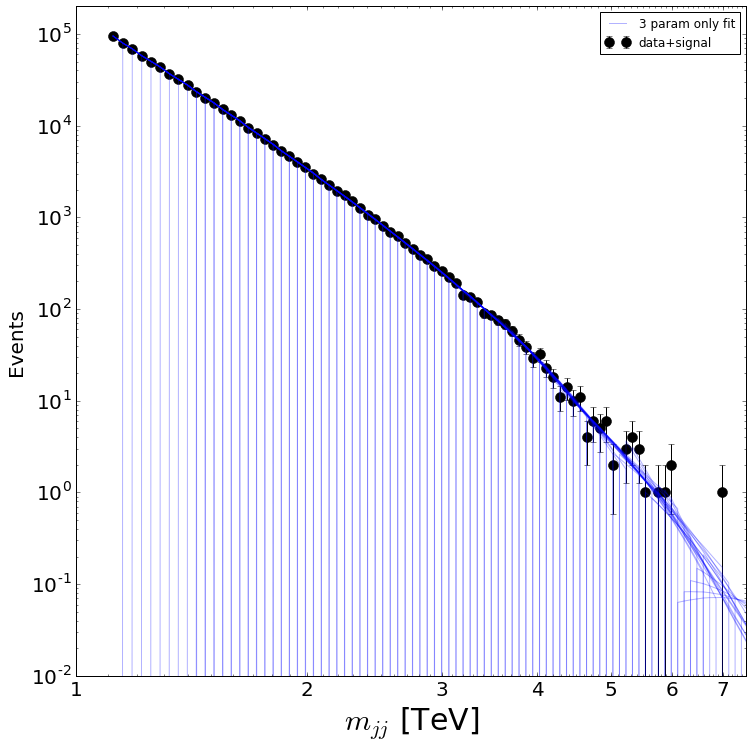

In [12]:
makePrettyPlots_bkgFits(xvalO, yvalO, (modelMatrix).tolist(), "", ymax = 2e5)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log


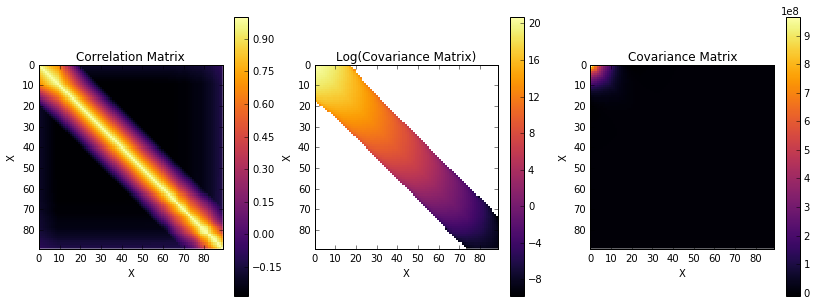

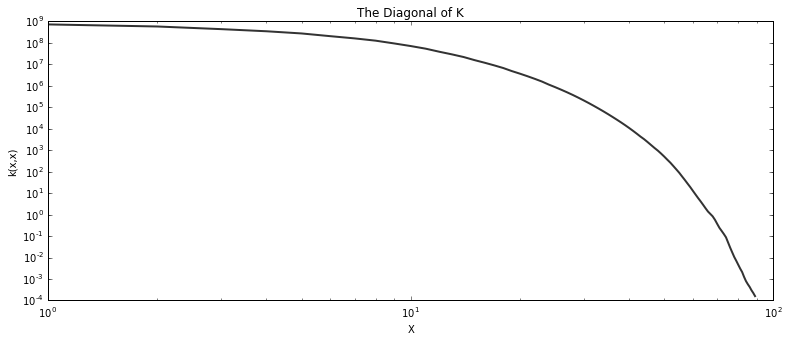

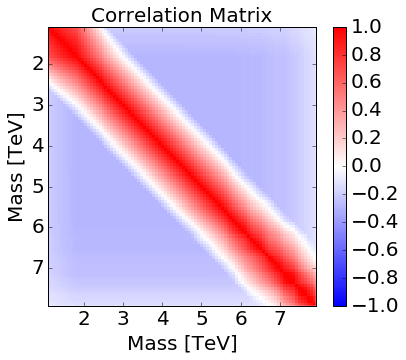

In [16]:
plot_cov(np.arange(0,len(xvalO),1).reshape(-1,1), corMat, covMat, False)
plot_cor(np.arange(0,len(xvalO),1).reshape(-1,1), corMat, False)

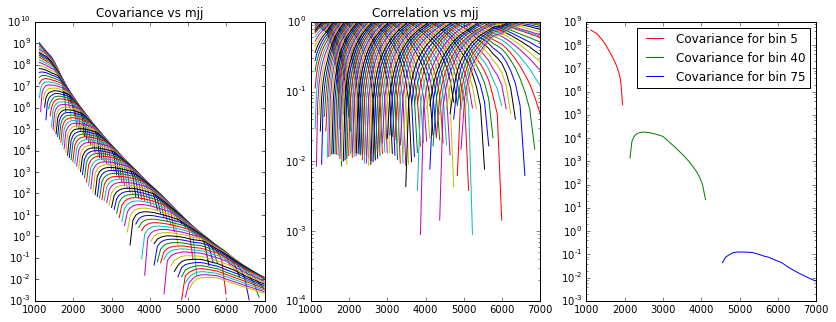

In [14]:
plot_individualCov(corMat, covMat)